## Smooth Face Cropper

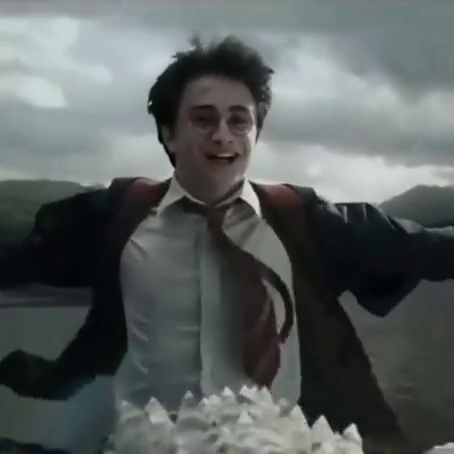

In [1]:
from SmoothFaceCropper import utils

image = utils.get_frame('media/reface1.mp4', 100)
image = utils.cv_2_image(image)
image

### Face landmarks detections with face-alignment

In the whole project I used the face_alignment library

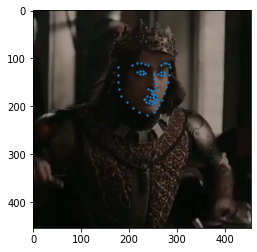

In [2]:
import matplotlib.pyplot as plt
import face_alignment
from skimage import io

fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False, device='cpu')

image = utils.get_frame('media/reface1.mp4', 300)
preds = fa.get_landmarks(image)

plt.imshow(image)
for detection in preds:
    plt.scatter(detection[:,0], detection[:,1], 2)

### Cropping

I implemented my feature to crop the face from the image in the crop file. *Padding* - a variable that indicates how much padding to do around the face. *With_rotation* - indicates whether to remove the head tilt or not. You can view the processing of corner cases in the test notebook.

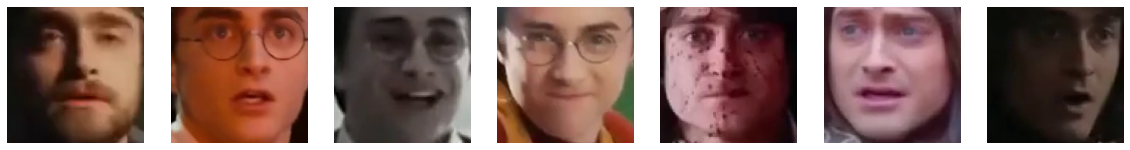

In [4]:
from SmoothFaceCropper import crop

fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False, device='cpu')

# Simple
fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(20, 5))
for i in range(7):
    image = utils.get_frame('media/reface1.mp4', 50*i)
    image = crop.crop(image, fa)[0]
    axs[i].axis('off')
    axs[i].imshow(image);

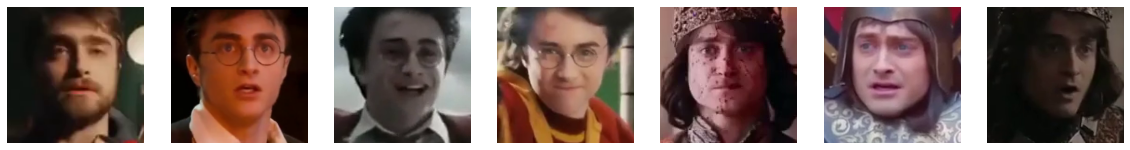

In [5]:
# With padding
fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(20, 5))
for i in range(7):
    image = utils.get_frame('media/reface1.mp4', 50*i)
    image = crop.crop(image, fa, padding=0.3)[0]
    axs[i].axis('off')
    axs[i].imshow(image);

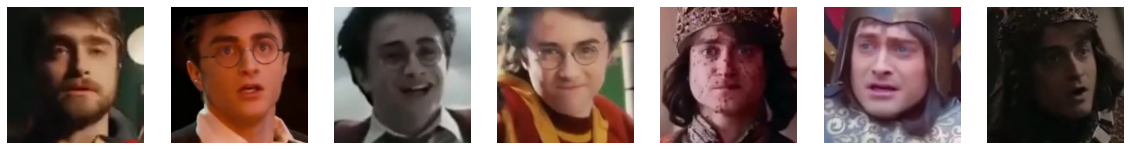

In [6]:
# With padding & rotation
fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(20, 5))
for i in range(7):
    image = utils.get_frame('media/reface1.mp4', 50*i)
    image = crop.crop(image, fa, padding=0.3, with_rotation=True)[0]
    axs[i].axis('off')
    axs[i].imshow(image);

## Image overlay

Here you can see the results of the overlay method.

In [4]:
import PIL

plus = PIL.Image.open(f'media/plus.png')
equal = PIL.Image.open(f'media/equal.png')

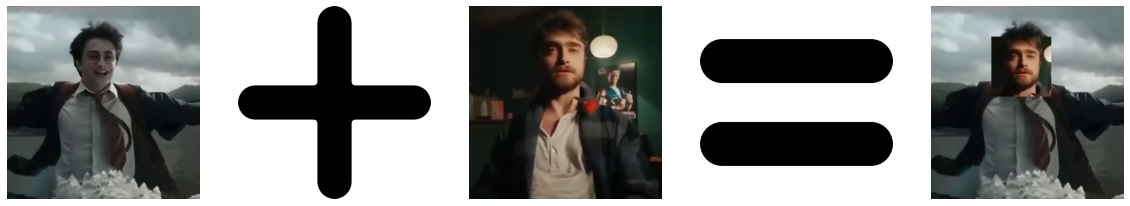

In [5]:
from SmoothFaceCropper import face_swap

src_image = utils.get_frame('media/reface1.mp4', 0)
src_cropped_image, src_borders = crop.crop(src_image, fa, padding=0.3)

target_image = utils.get_frame('media/reface1.mp4', 100)
target_cropped_image, target_borders = crop.crop(target_image, fa, padding=0.3)

image = face_swap.overlay(target_image, src_cropped_image, target_borders)

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
axs[0].imshow(target_image)
axs[1].imshow(plus)
axs[2].imshow(src_image)
axs[3].imshow(equal)
axs[4].imshow(image)
for i in range(5):
    axs[i].axis('off')

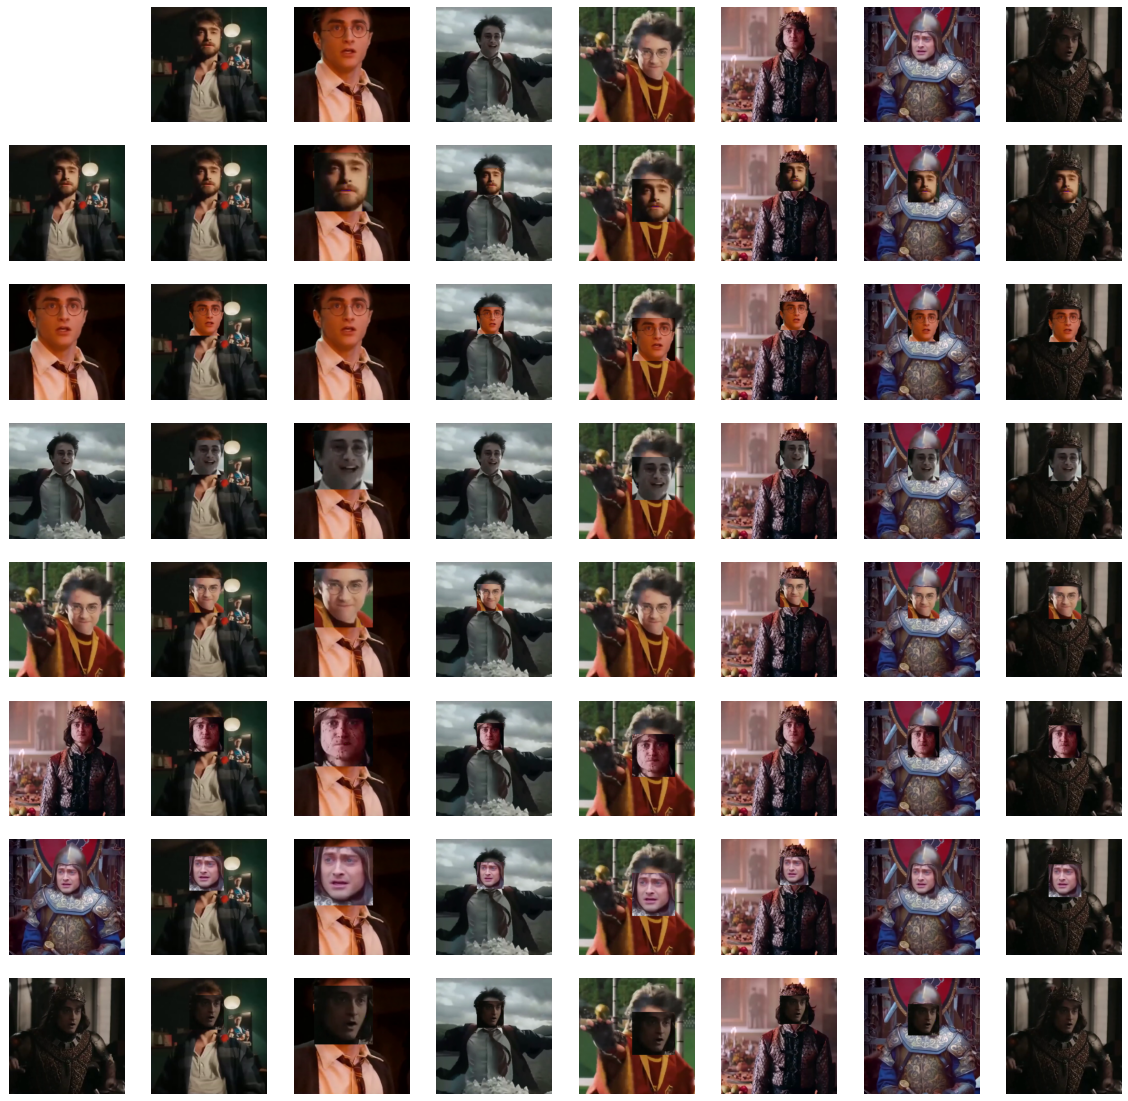

In [8]:
fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(20, 20))
axs[0][0].axis('off')

for i in range(1, 8):
    src_image = utils.get_frame('media/reface1.mp4', (i-1)*50)
    axs[i][0].imshow(src_image)
    axs[0][i].imshow(src_image)
    axs[i][0].axis('off')
    axs[0][i].axis('off')

for i in range(1, 8):
    src_image = utils.get_frame('media/reface1.mp4', (i-1)*50)
    src_cropped_image = crop.crop(src_image, fa, padding=0.1)[0]
    
    for j in range(1, 8):
        target_image = utils.get_frame('media/reface1.mp4', (j-1)*50)
        target_cropped_image, target_borders = crop.crop(target_image, fa, padding=0.1)

        image = face_swap.overlay(target_image, src_cropped_image, target_borders)

        axs[i][j].imshow(image)
        axs[i][j].axis('off')

### Face Swap

And finally, all together with the phase shifter. I still haven't figured out why the method doesn't work. There seems to be a problem with the weights. I took the inference code from the original github repo: https://github.com/taotaonice/FaceShifter/blob/master/inference_demo.py.

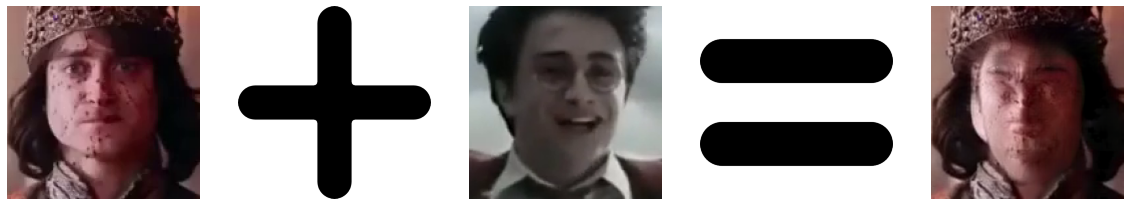

In [6]:
from SmoothFaceCropper import face_swap

fs = face_swap.FaceSwapper()

src_image = utils.get_frame('media/reface1.mp4', 100)
target_image = utils.get_frame('media/reface1.mp4', 200)
src_cropped_image = crop.crop(src_image, fa, padding=0.3)[0]
target_cropped_image = crop.crop(target_image, fa, padding=0.3)[0]

generated_image = fs.generate(src_cropped_image, target_cropped_image)

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
axs[0].imshow(target_cropped_image)
axs[1].imshow(plus)
axs[2].imshow(src_cropped_image)
axs[3].imshow(equal)
axs[4].imshow(generated_image)
for i in range(5):
    axs[i].axis('off')

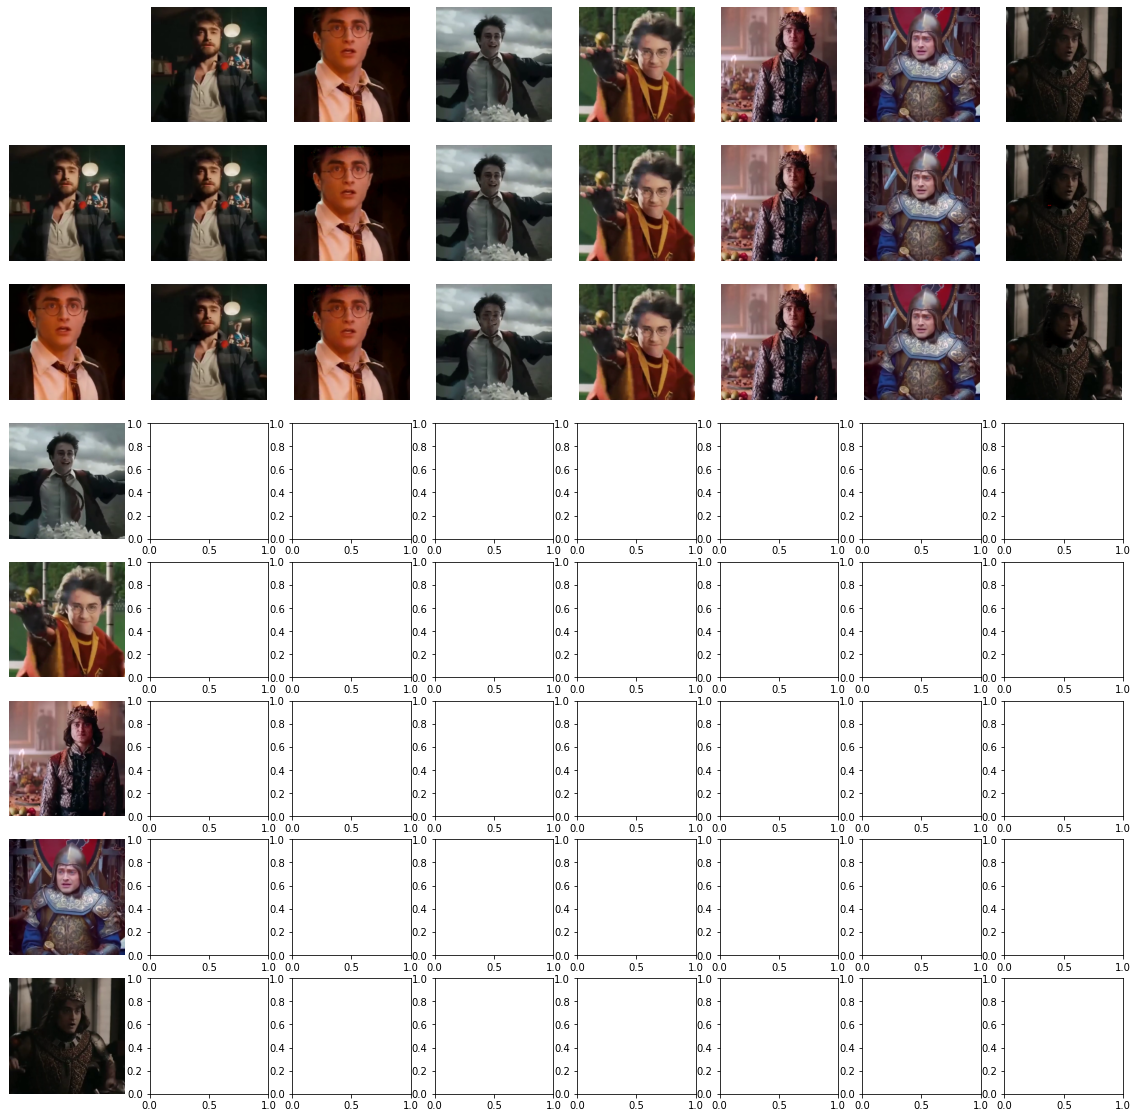

In [23]:
fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(20, 20))
axs[0][0].axis('off')
for i in range(1, 8):
    src_image = utils.get_frame('media/reface1.mp4', (i-1)*50)
    axs[i][0].imshow(src_image)
    axs[0][i].imshow(src_image)
    axs[i][0].axis('off')
    axs[0][i].axis('off')

# it works too long on cpu, you can speed up this inferance with passing device='cuda' in fs
for i in range(1, 8):
    src_image = utils.get_frame('media/reface1.mp4', (i-1)*50)
    src_cropped_image = crop.crop(src_image, fa, padding=0.3)[0]
    for j in range(1, 8):
        target_image = utils.get_frame('media/reface1.mp4', (j-1)*50)
        target_cropped_image, target_borders = crop.crop(target_image, fa, padding=0.3)

        generated_image = fs.generate(src_cropped_image, target_cropped_image) * 255
        image = face_swap.overlay(target_image, generated_image, target_borders)
        
        axs[i][j].imshow(image)
        axs[i][j].axis('off')

### Video processing

The method is applied to the video

In [ ]:
from tqdm import tqdm

fs = face_swap.FaceSwapper()
src_image = utils.get_frame('media/reface1.mp4', 50)
src_cropped_image = crop.crop(src_image, fa, padding=0.1)[0]
frames = utils.get_all_frames('media/reface1.mp4')
generated_frames = []
for idx, f in tqdm(enumerate(frames[:100])):
    try:
        target_cropped_image, target_borders = crop.crop(f, fa, padding=0.1)
        generated_image = fs.generate(src_cropped_image, target_cropped_image) * 255
        image = face_swap.overlay(f, generated_image, target_borders)
        generated_frames.append(image)
    except Exception:
        # Skip frame with no faces
        generated_frames.append(f)

In [10]:
utils.write_video('gen.avi', generated_frames, 30)